In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import torch
from greedy_models.tree_mono_glm import Tree_Mono_GLM

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)

In [3]:
T_train = 999 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 500
sub_no = 10
E_no = E_neural.shape[1]
I_no = I_neural.shape[1]
device = torch.device("cuda")

batch_size = 15000
iter_no = 9990
epoch_no = iter_no*batch_size//T_train 
print(epoch_no)

3


In [4]:
V_train = V[:T_train].to(device)
V_test = V[T_train:T_train + T_test].to(device)

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

In [5]:
batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = Tree_Mono_GLM(sub_no, E_no, I_no, T_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.98)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

23065


In [ ]:
temp_list = np.logspace(0,-3,50)
temp_count = 0

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    temp = temp_list[temp_count]
    if (i%50 == 49) & (temp_count < 49):
        temp_count += 1
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size]
    
    batch_pred, out_filters, C_den, C_syn_e, C_syn_i = model(batch_E_neural,
                                                            batch_I_neural, temp, False)
    loss = torch.var(batch_pred - batch_V)
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if i%50 == 0:
        model.eval()
        test_V_pred, test_out_filters, test_C_den, test_C_syn_e, test_C_syn_i = model(test_E_neural,
                                                            test_I_neural, 0, True)
            
        test_score = metrics.explained_variance_score(y_true=V_test.cpu().detach().numpy(),
                                                      y_pred=test_V_pred.cpu().detach().numpy())
        print(i, test_score)

<ipython-input-7-3d0ae597e7e6>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 0.03469994728103165
50 0.3890806532362344
100 0.0894261352708321
150 -0.07234599638005457
200 -0.6804113521178812
250 -0.7477022030136378
300 -0.793196827337078
350 -0.8194344907967372
400 -0.7813798201618034
450 -0.4811532792742812
500 -0.03890227173644356
550 -0.3762301462969466
600 0.013758024840826555
650 -0.0014526232675775574
700 0.4518646782311627


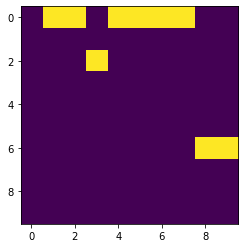

In [9]:
plt.imshow(test_C_den.cpu().detach().numpy())

[ 0.00662976 -0.00662966 -0.04390217 -0.01490919  0.09496507  0.2778188
 -0.29095367 -0.24090323 -0.24492374  0.28573364 -0.4844188  -0.44702306
 -0.17056416 -0.07659491  0.16495818 -0.28618488 -0.26786077  0.0073998
  0.05709741  0.12942576  0.29287538 -0.26676297 -0.3170605  -0.26338133
 -0.20621073  0.0874066  -0.06178669  0.18973874 -0.3878572  -0.4351763
 -0.43756425 -0.27005085  0.07800978  0.19365297  0.1647183   0.24838051
 -0.45871824 -0.49675274 -0.50996643 -0.4266008  -0.13192807  0.30309632
  0.23198429  0.21367483]


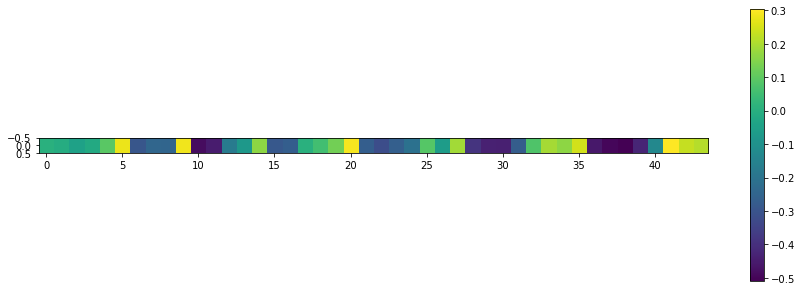

In [18]:
plt.figure(figsize=(15,5))
plt.imshow(model.C_den_raw.cpu().detach().numpy().reshape(1,-1))
plt.colorbar()
print(model.C_den_raw.cpu().detach().numpy())

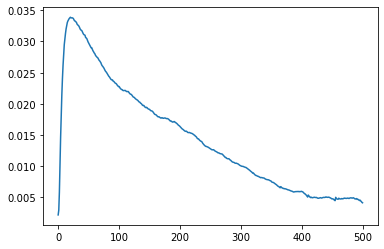

In [22]:
#fig, axs = plt.subplots(nrows = sub_no, figsize = (15,15))
#for i in range(sub_no):
    #axs[i].plot(test_out_filters[i].cpu().detach().numpy())
    
plt.plot(test_out_filters[0].cpu().detach().numpy())

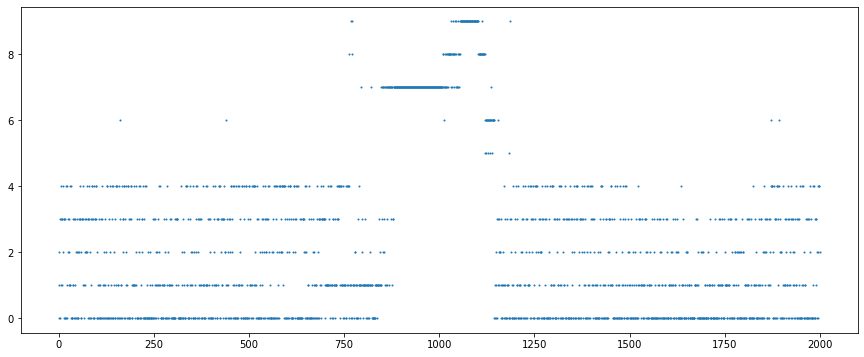

In [12]:
clust = np.zeros((E_no))

for i in range(E_no):
    clust[i] = torch.argmax(test_C_syn_e[:,i])

plt.figure(figsize = (15,6))
plt.scatter(np.arange(E_no), clust, s=1)

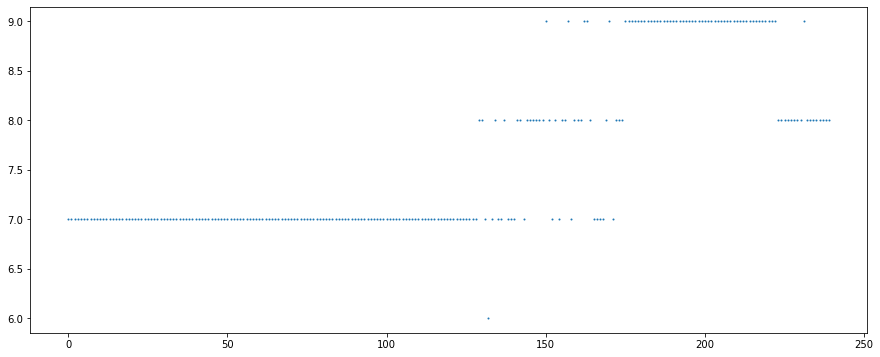

In [20]:
plt.figure(figsize = (15,6))
plt.scatter(np.arange(240), clust[880:1120], s=1)

In [13]:
eloc = np.load("/media/hdd01/sklee/CA1_clust4-60/data/Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy")

peak = np.zeros((E_no, 2))
subunit = np.zeros((E_no, 2))

for i in range(E_no):
    clust_idx = torch.argmax(test_C_syn_e[:,i])
    
    peak[i,0] = torch.argmax(test_out_filters[clust_idx])
    peak[i,1] = eloc[i,0]
    
    subunit[i,0] = clust_idx
    subunit[i,1] = eloc[i,0]


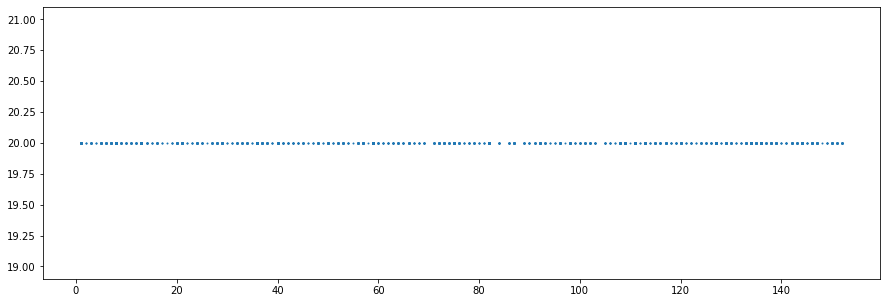

In [14]:
plt.figure(figsize = (15,5))
plt.scatter(peak[:,1], peak[:,0], s=1)

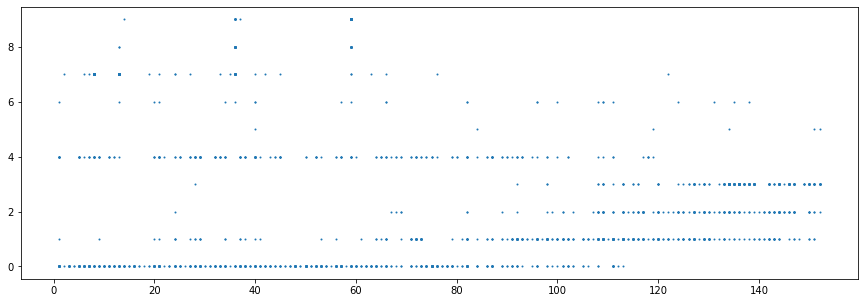

In [15]:
plt.figure(figsize = (15,5))
plt.scatter(subunit[:,1], subunit[:,0], s=1)